# Painless machine learning with AutoML

In [1]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2ODeepLearningEstimator
from h2o.explanation import explain
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,15 hours 52 mins
H2O_cluster_timezone:,Europe/Warsaw
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.32.0.3
H2O_cluster_version_age:,1 month and 5 days
H2O_cluster_name:,H2O_from_python_root_7kueog
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.028 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


## Loading the data

In [2]:
data = h2o.import_file('train.csv')
data["Survived"] = data["Survived"].asfactor()
data.show()

Parse progress: |█████████████████████████████████████████████████████████| 100%


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,nan,7.25,,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,nan,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,nan,7.925,,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,,S
6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.4583,,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.075,,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,,S
10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14,1,0,237736,30.0708,,C


In [3]:
target = "Survived"
predictors = data.columns
for col in ["PassengerId", "Name", target]: predictors.remove(col)

In [4]:
train, test = data.split_frame(ratios = [0.8], seed=1234)

## Choosing a model ourselves

In [5]:
nn_model = H2ODeepLearningEstimator(seed=1234)
nn_model.train(x=predictors, y=target, training_frame=train, validation_frame=test)

deeplearning Model Build progress: |██████████████████████████████████████| 100%


In [6]:
accuracy = nn_model.model_performance(test).accuracy()
# The accuracy has [[threshold, max_accuracy]] format, printing only the actual accuracy:
print(f"Accuracy: {round(accuracy[0][1]*100, 2)}%") 

Accuracy: 83.24%


## Finding the best model using AutoML

In [7]:
aml = H2OAutoML(max_models=20, seed=1234)
aml.train(x=predictors, y=target, training_frame=train)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [8]:
lb = aml.leaderboard
lb.head()

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
StackedEnsemble_BestOfFamily_AutoML_20210130_135658,0.866274,0.410865,0.842766,0.185281,0.355732,0.126545
StackedEnsemble_AllModels_AutoML_20210130_135658,0.862112,0.415247,0.839424,0.187168,0.358223,0.128324
XGBoost_grid__1_AutoML_20210130_135658_model_3,0.861635,0.428583,0.841435,0.185834,0.358162,0.12828
XRT_1_AutoML_20210130_135658,0.859212,0.446911,0.825682,0.200456,0.373889,0.139793
XGBoost_1_AutoML_20210130_135658,0.857241,0.437655,0.826744,0.187518,0.366948,0.134651
GBM_4_AutoML_20210130_135658,0.854156,0.454442,0.820485,0.208906,0.378251,0.143074
GBM_grid__1_AutoML_20210130_135658_model_2,0.853155,0.450833,0.806123,0.198852,0.377532,0.142531
XGBoost_grid__1_AutoML_20210130_135658_model_1,0.852856,0.437599,0.822237,0.198016,0.370587,0.137335
XGBoost_3_AutoML_20210130_135658,0.851956,0.44751,0.826986,0.179068,0.366898,0.134614
DRF_1_AutoML_20210130_135658,0.850293,0.569349,0.803809,0.211696,0.383852,0.147342


In [9]:
leader = aml.leader
accuracy = leader.model_performance(test).accuracy()
print(f"Accuracy: {round(accuracy[0][1]*100, 2)}%") 

Accuracy: 88.27%


## Bonus: Explainable AI

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_AutoML_20210130_135658


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5230518476403966: 


,0,1,Error,Rate
0,438.0,9.0,0.0201,(9.0/447.0)
1,42.0,223.0,0.1585,(42.0/265.0)
Total,480.0,232.0,0.0716,(51.0/712.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

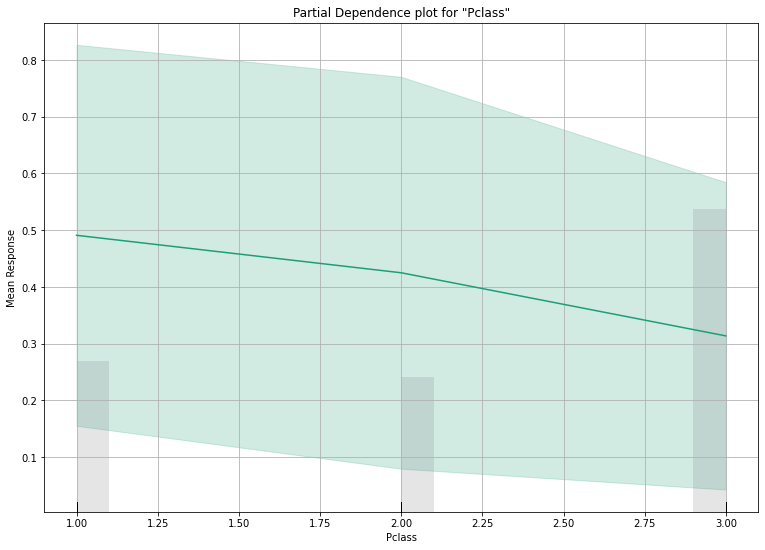

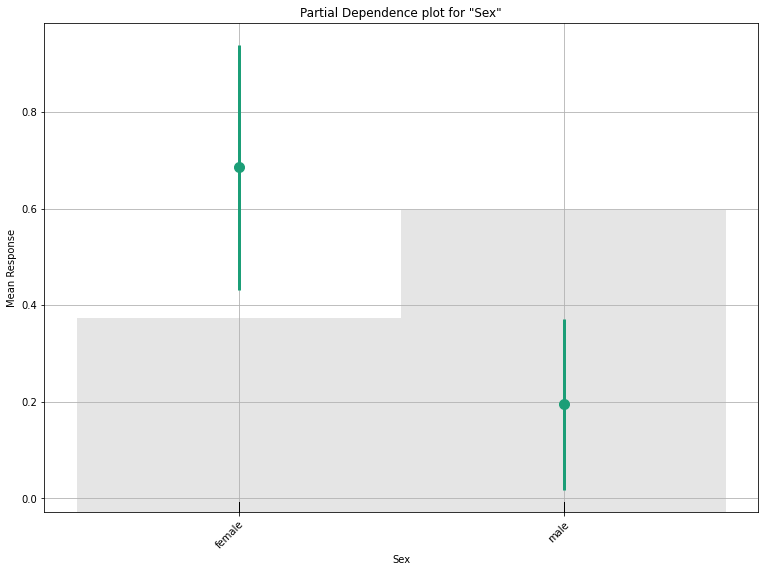

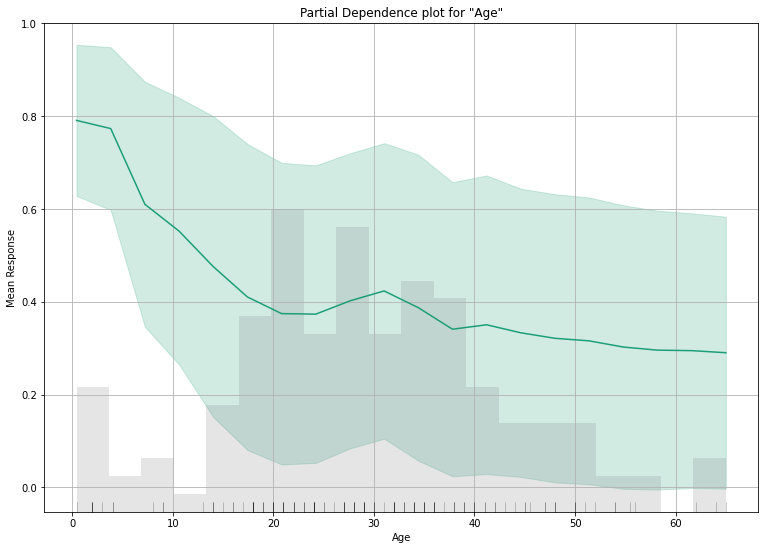

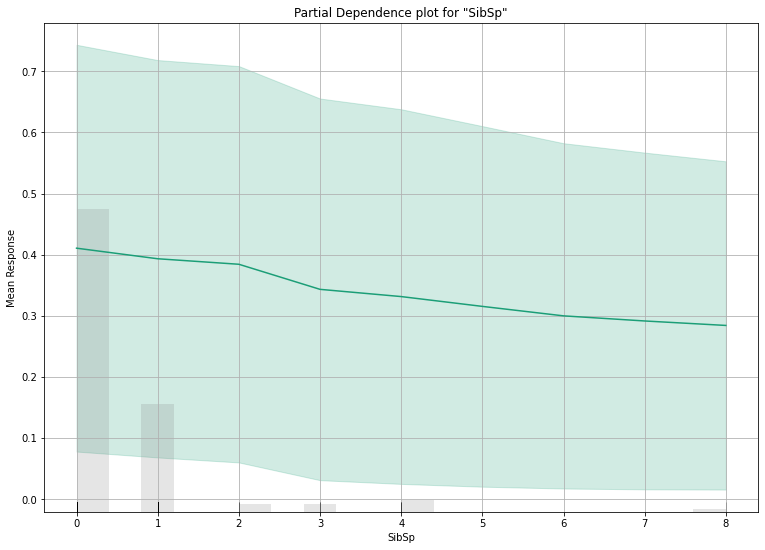

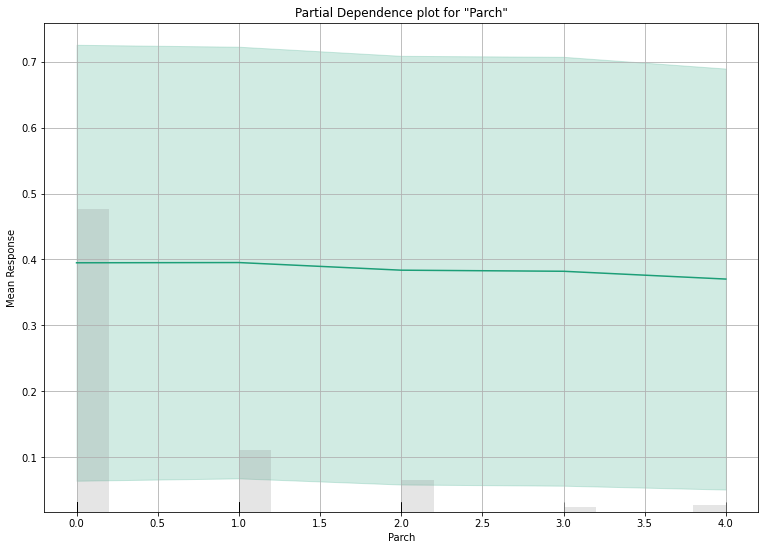

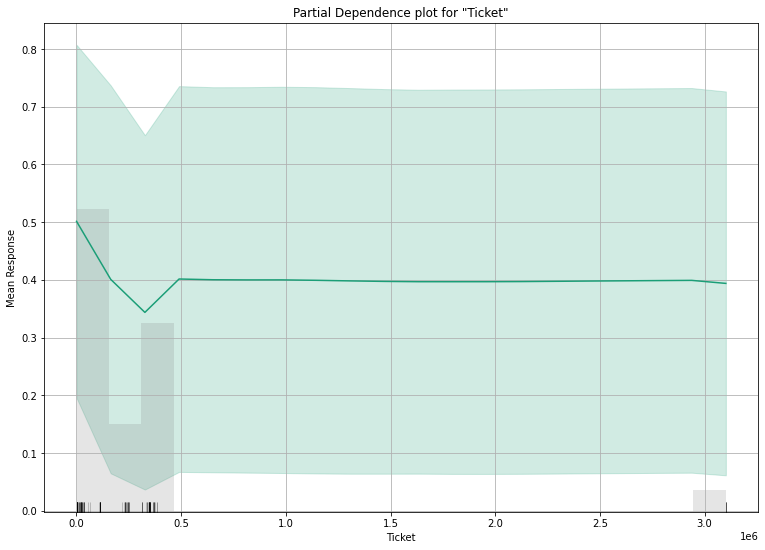

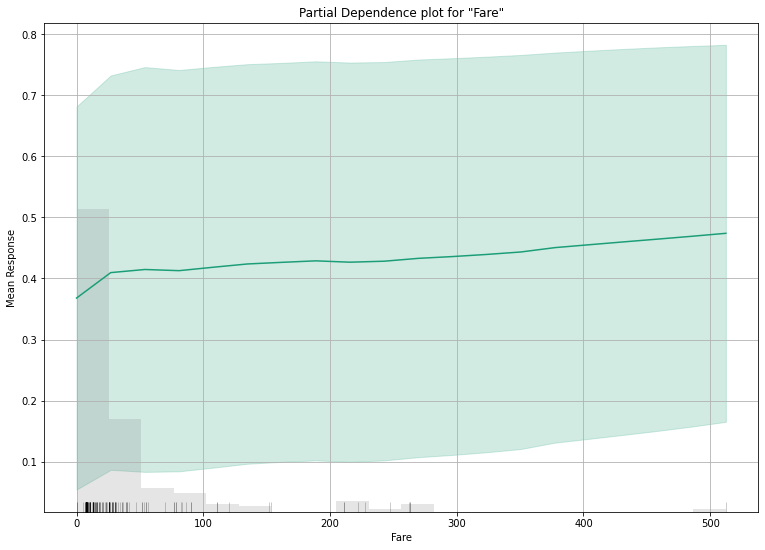

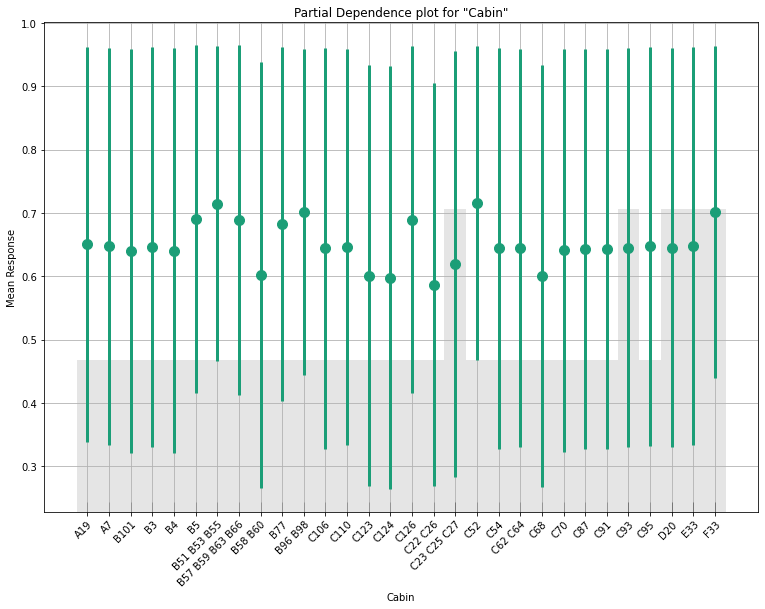

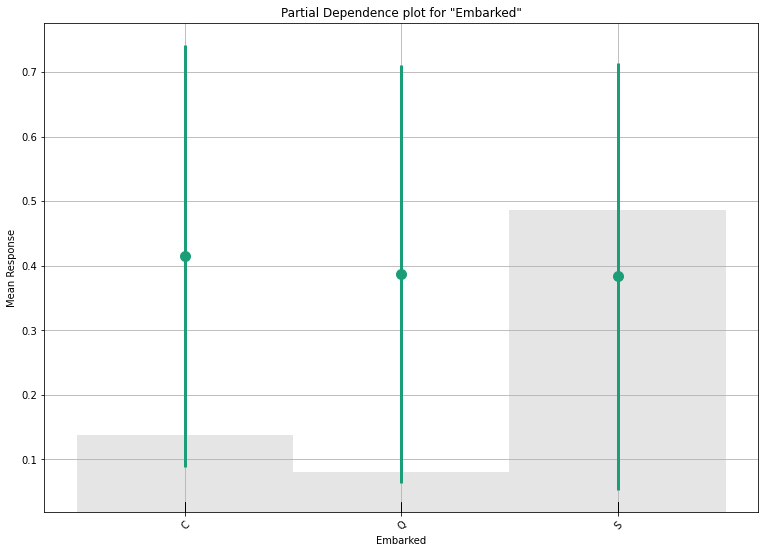

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## StackedEnsemble_BestOfFamily_AutoML_20210130_135658


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.5230518476403966: 


,0,1,Error,Rate
0,438.0,9.0,0.0201,(9.0/447.0)
1,42.0,223.0,0.1585,(42.0/265.0)
Total,480.0,232.0,0.0716,(51.0/712.0)


# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

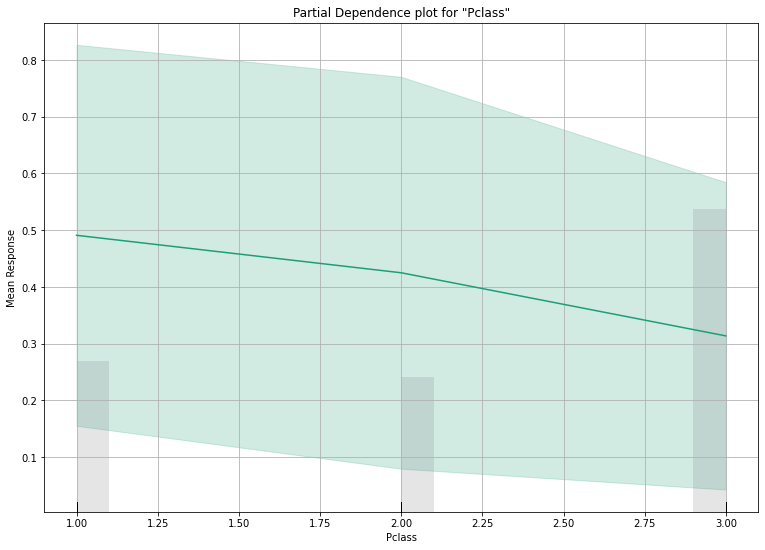

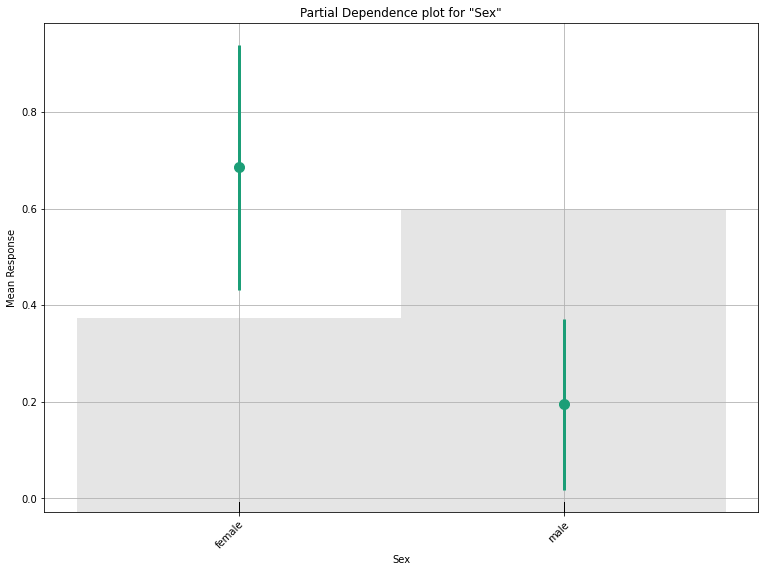

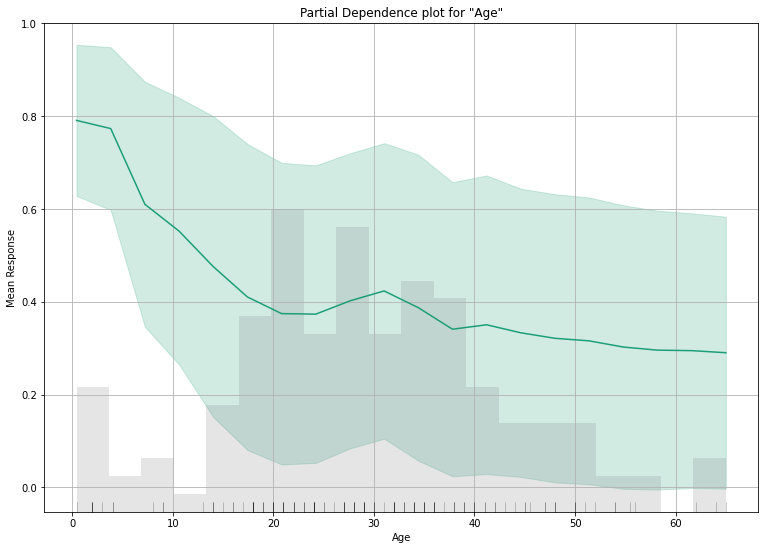

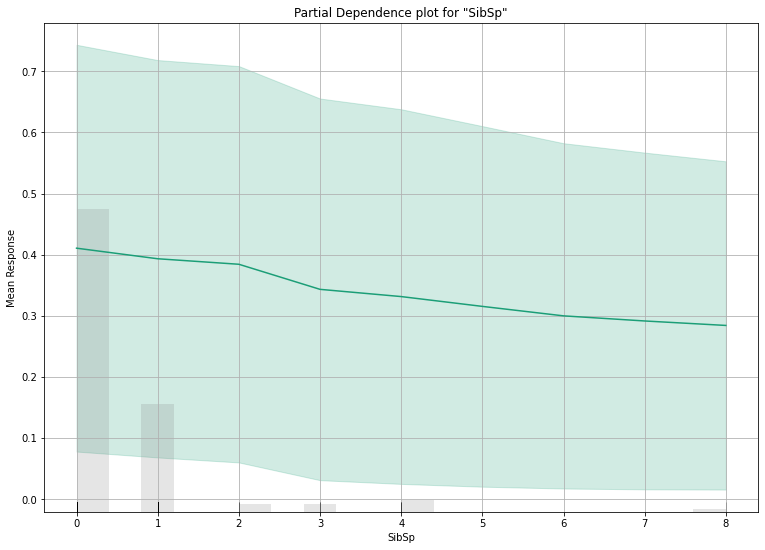

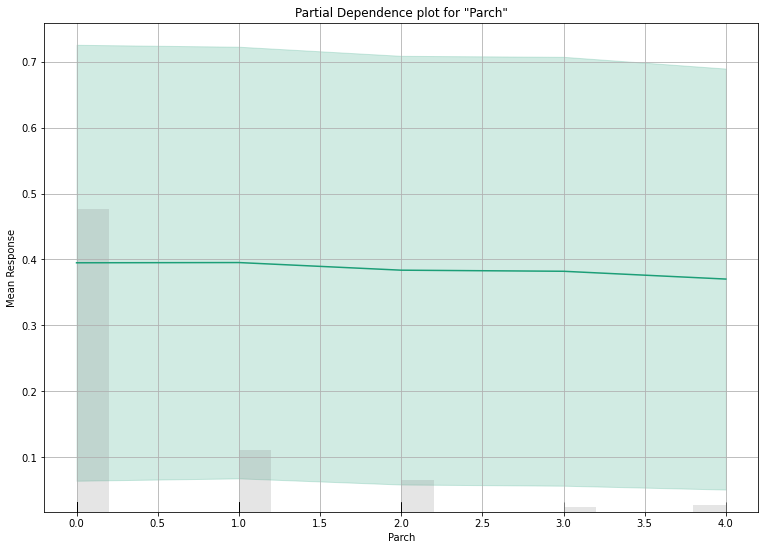

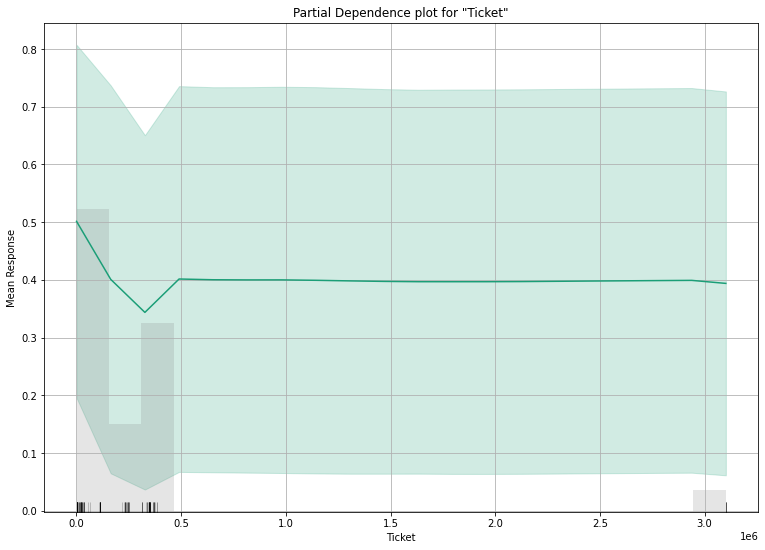

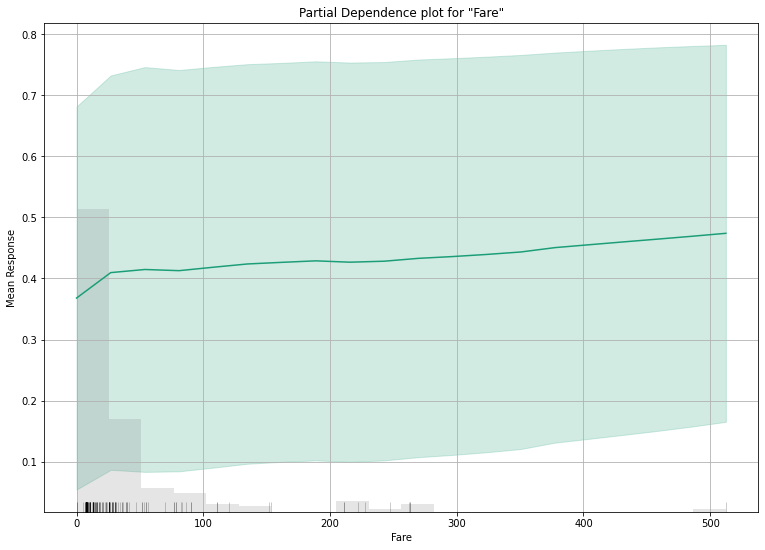

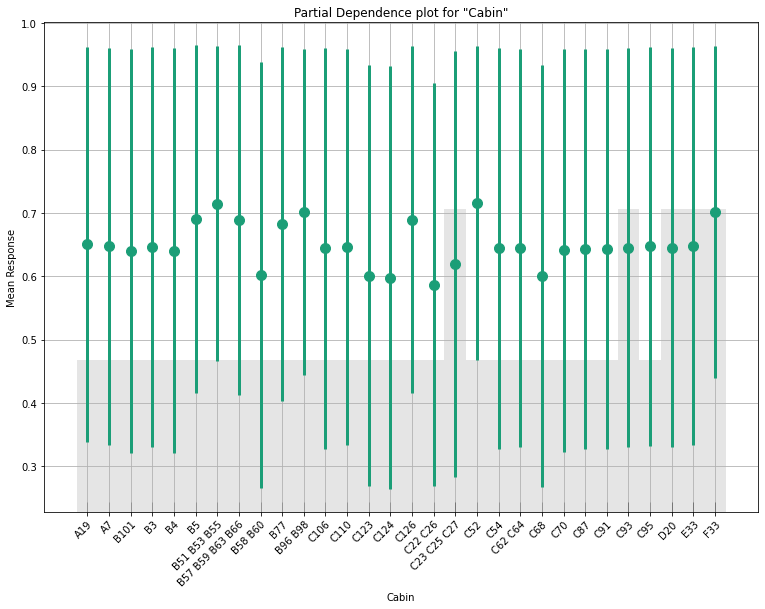

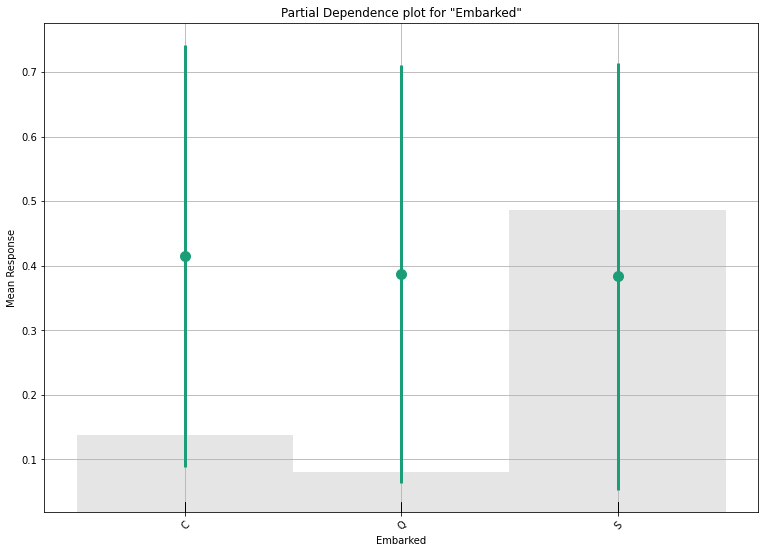

In [10]:
explain(leader, test)

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_grid__1_AutoML_20210129_222349_model_3


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4652104079723358: 


,0,1,Error,Rate
0,430.0,17.0,0.038,(17.0/447.0)
1,40.0,225.0,0.1509,(40.0/265.0)
Total,470.0,242.0,0.0801,(57.0/712.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

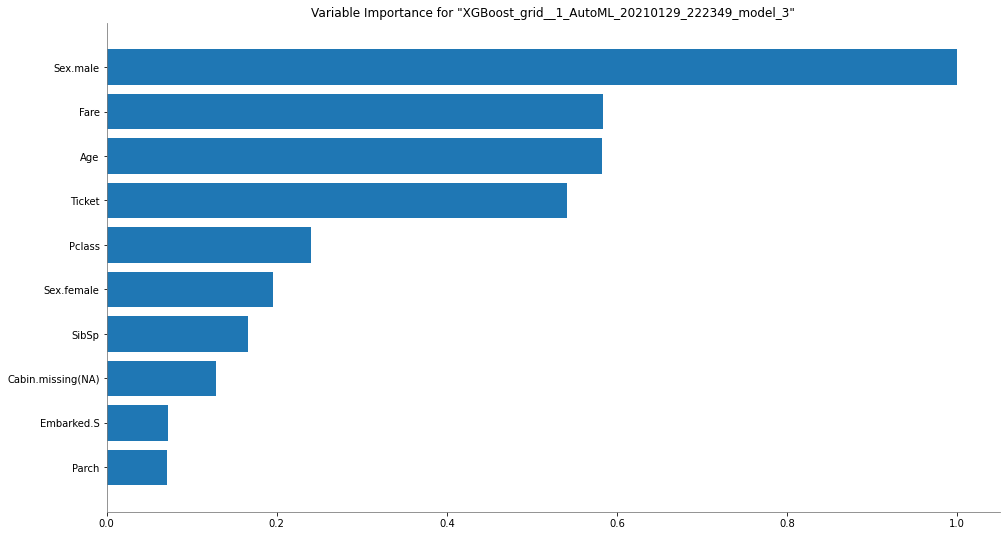

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

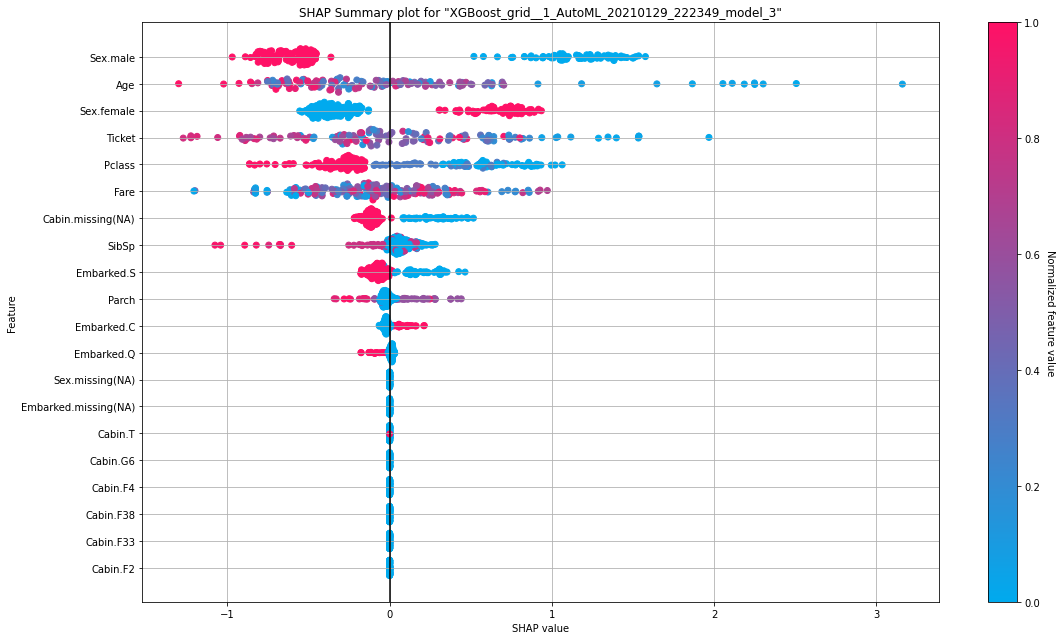

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

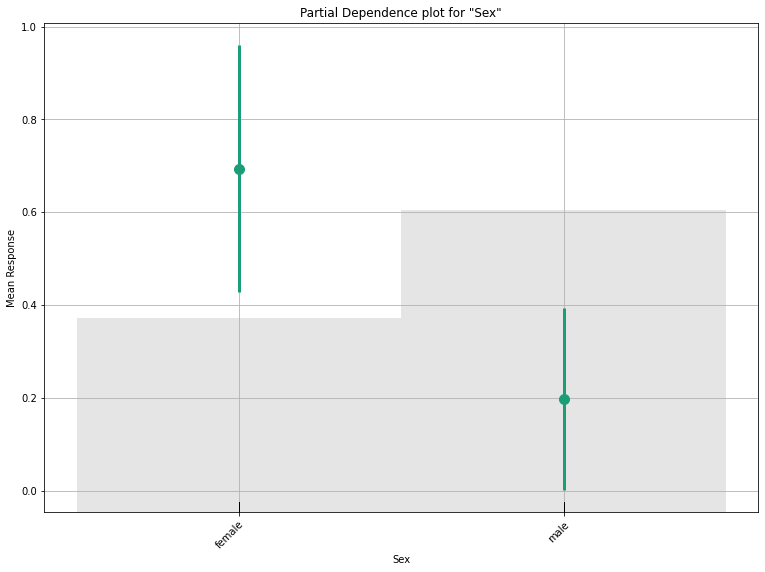

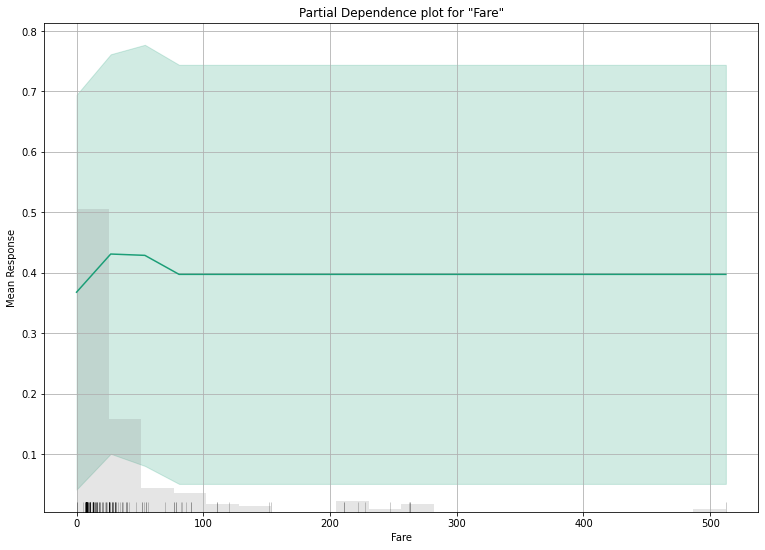

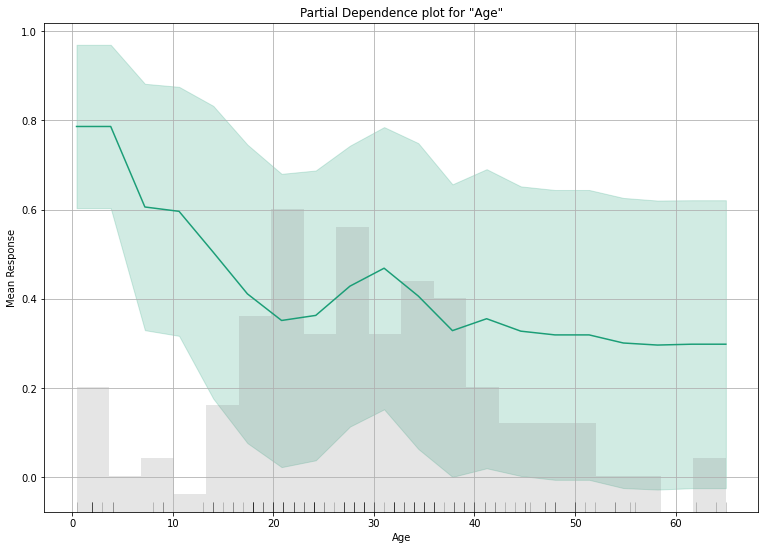

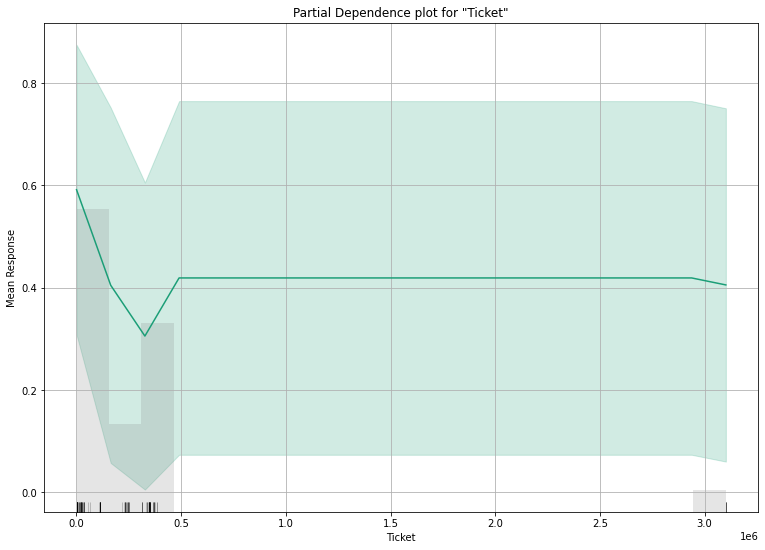

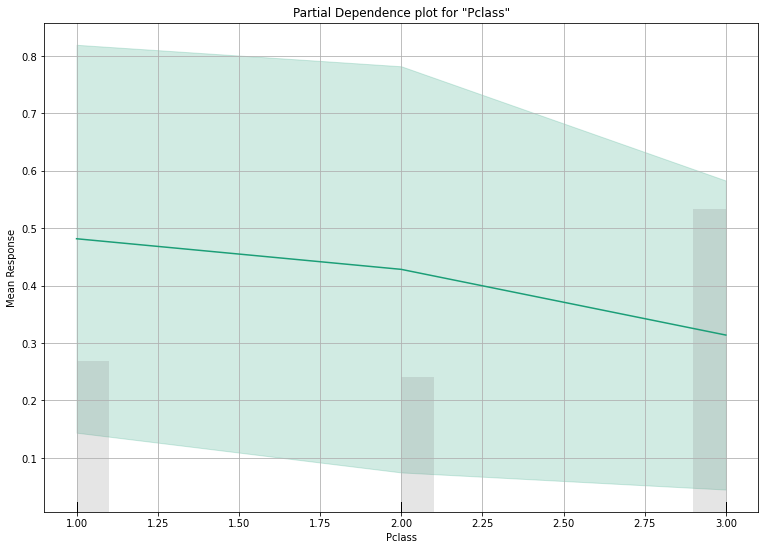

# Confusion Matrix

> Confusion matrix shows a predicted class vs an actual class.

## XGBoost_grid__1_AutoML_20210129_222349_model_3


Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4652104079723358: 


,0,1,Error,Rate
0,430.0,17.0,0.038,(17.0/447.0)
1,40.0,225.0,0.1509,(40.0/265.0)
Total,470.0,242.0,0.0801,(57.0/712.0)


# Variable Importance

> The variable importance plot shows the relative importance of the most important variables in the model.

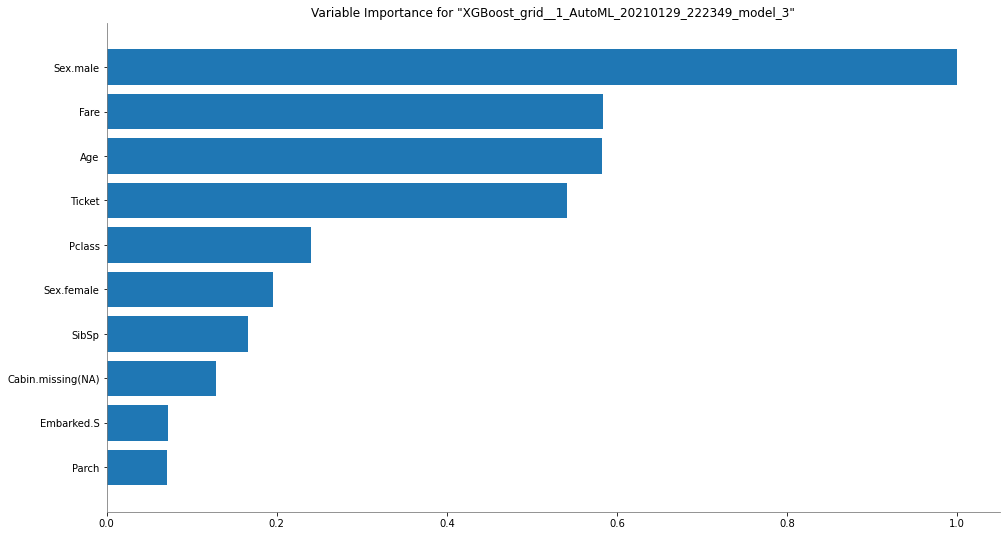

# SHAP Summary

> SHAP summary plot shows the contribution of the features for each instance (row of data). The sum of the feature contributions and the bias term is equal to the raw prediction of the model, i.e., prediction before applying inverse link function.

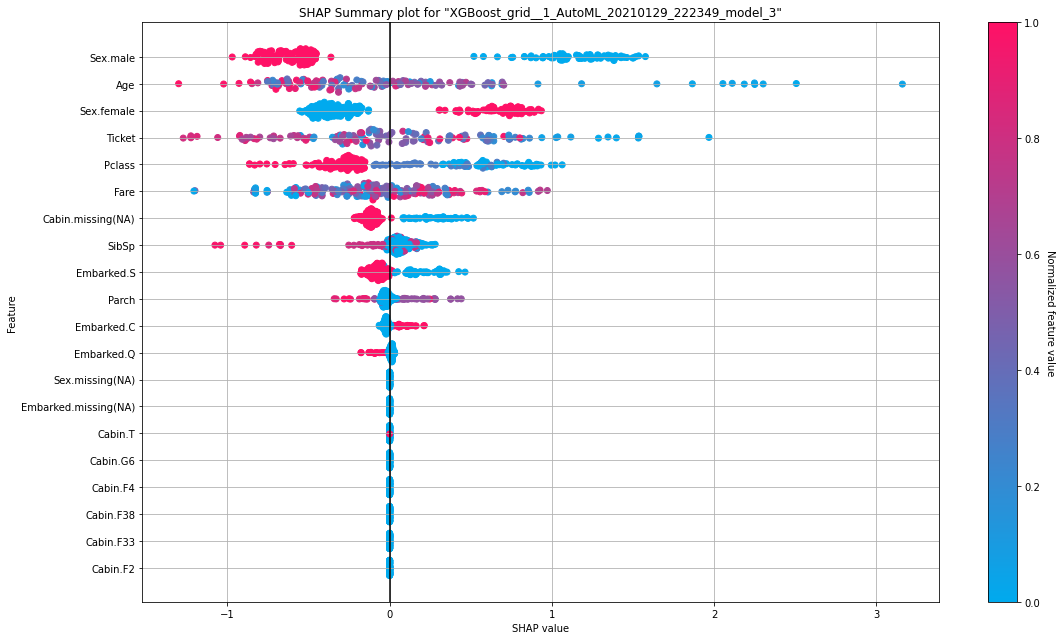

# Partial Dependence Plots

> Partial dependence plot (PDP) gives a graphical depiction of the marginal effect of a variable on the response. The effect of a variable is measured in change in the mean response. PDP assumes independence between the feature for which is the PDP computed and the rest.

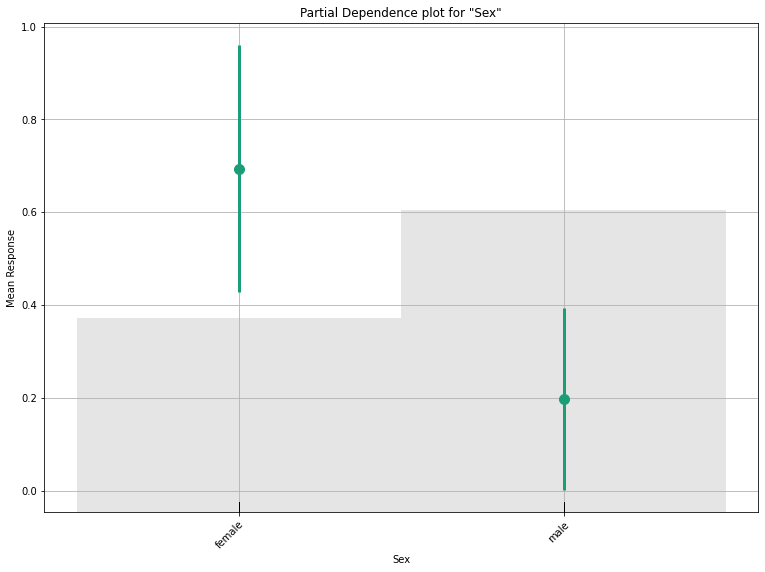

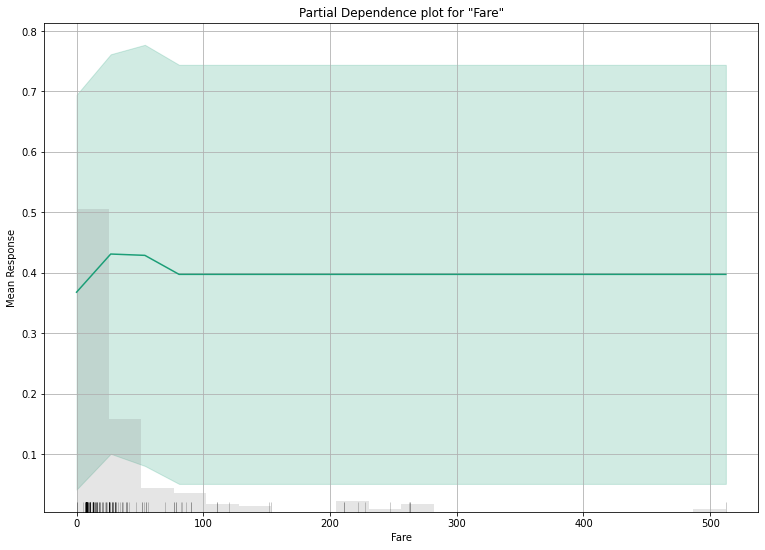

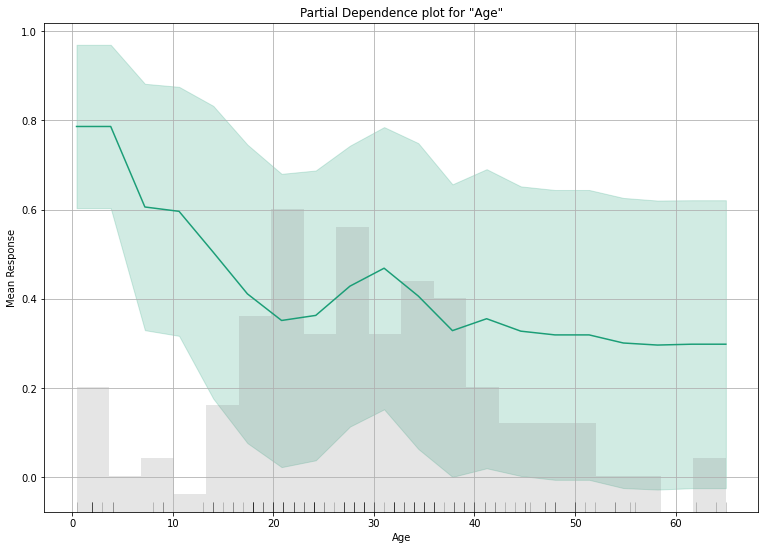

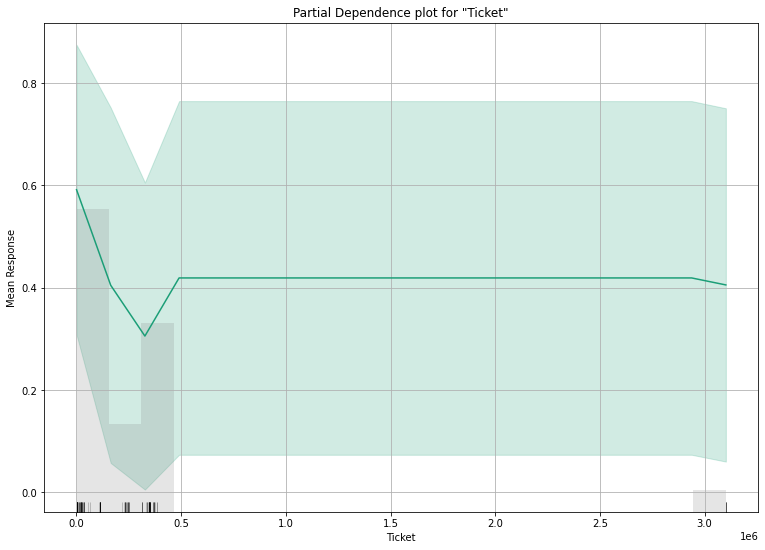

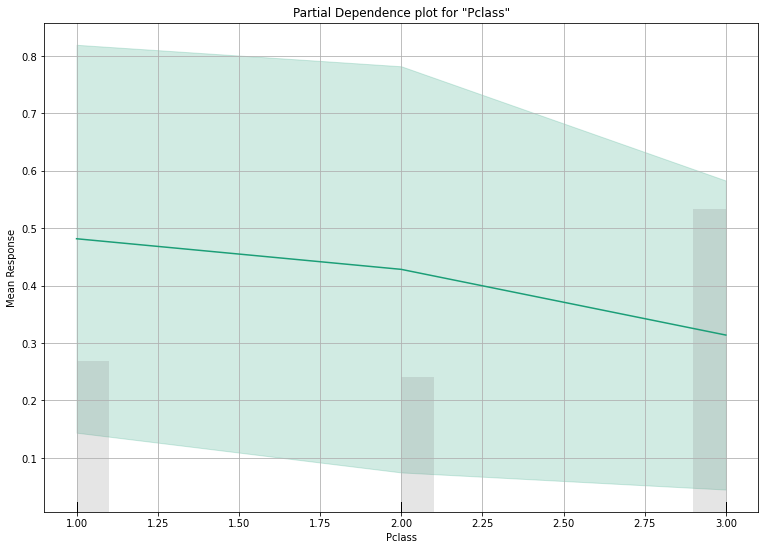

In [11]:
explain(h2o.get_model('XGBoost_grid__1_AutoML_20210129_222349_model_3'), test)